In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
manjilkarki_deepfake_and_real_images_path = kagglehub.dataset_download('manjilkarki/deepfake-and-real-images')

print('Data source import complete.')


Using Colab cache for faster access to the 'deepfake-and-real-images' dataset.
Data source import complete.


# Model Card for sakshamkr1/deepfake-fb-deit-vit-224

## Model Description
This model is a fine-tuned Vision Transformer (ViT) based on `facebook/deit-base-patch16-224` for deepfake image classification. It was trained on the [Deepfake and Real Images](https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images) dataset.

## Intended Uses
This model is intended for research purposes related to deepfake detection and image classification. It can be used to classify images as either 'Fake' or 'Real'.

## Training Data
The model was trained on the [Deepfake and Real Images](https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images) dataset available on Kaggle. The dataset contains both deepfake and real images. Random over-sampling was applied to balance the classes during training.

## Training Procedure
The model was fine-tuned using the Hugging Face `transformers` library and `Trainer` class. The training was performed for 5 epochs with a learning rate of 2e-5 and weight decay of 0.01. Mixed-precision training was enabled.

## Evaluation Results
The model was evaluated on a test set with the following metrics:

- **Accuracy:** 0.9871
- **Macro F1-Score:** 0.9871
- **AUROC:** 0.9993

A classification report, confusion matrix, and ROC curve are available in the output directory.

## How to Use
You can use this model with the Hugging Face `transformers` library.

In [ ]:
%pip install --upgrade scikit-learn imbalanced-learn tqdm datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 127.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.7/146.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.3/377.3 kB 35.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-lear

In [ ]:
# =================================================================================================
# Deepfake vs. Real Image Classification using Vision Transformer (ViT) with PyTorch
#
# This script is optimized for a multi-GPU environment/TPU-enabled environment (e.g., Kaggle T4 x2) and reverts to
# the more stable PyTorch implementation.
#
# Key Features:
# 1.  PyTorch & Hugging Face Trainer: A robust and widely-used training framework.
# 2.  Multi-GPU and TPU Ready: The Hugging Face Trainer automatically handles Data Parallelism.
# 3.  Mixed-Precision Training: `fp16=True` is enabled for significant speed-up on T4 GPUs. 
# 4.  Comprehensive Evaluation: Includes Accuracy, Macro F1-Score, and AUROC, with
#     visualizations for the confusion matrix and ROC curve.
# =================================================================================================

# 1. SETUP AND IMPORTS
# =================================================================================================
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import torch
import itertools
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import ImageFile, Image

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score,
    roc_curve
)
from imblearn.over_sampling import RandomOverSampler
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
)
from torchvision.transforms import (
    Compose,
    Normalize,
    Resize,
    ToTensor,
    RandomRotation,
    RandomHorizontalFlip,
)
from scipy.special import softmax

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 2. CONFIGURATION
# =================================================================================================
# --- Dataset Configuration ---
DATA_DIR = Path(manjilkarki_deepfake_and_real_images_path+"/Dataset")

# --- Model Configuration ---
# We will download the model directly from the Hugging Face Hub.
# IMPORTANT: Ensure that "Internet" is turned ON in your Kaggle notebook's settings.
MODEL_NAME = 'facebook/deit-base-patch16-224'
OUTPUT_DIR = "deepfake-vit-finetuned-gpu"

# --- Training Configuration ---
NUM_TRAIN_EPOCHS = 5
# This batch size is per GPU. With 2 GPUs, the effective batch size is 32 * 2 = 64.
PER_DEVICE_TRAIN_BATCH_SIZE = 128
PER_DEVICE_EVAL_BATCH_SIZE = 128
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
print("Loading Complete")

Loading Complete


In [ ]:
manjilkarki_deepfake_and_real_images_path

'/kaggle/input/deepfake-and-real-images'

In [ ]:
# 3. DATA LOADING AND PREPARATION
# =================================================================================================
print("Starting data loading and preparation...")

# Load all image paths and labels from the dataset directory
file_paths = []
labels = []

for file in sorted(DATA_DIR.glob('*/*/*.*')):
    label = file.parent.name
    labels.append(label)
    file_paths.append(str(file))

print(f"Found {len(file_paths)} images.")

# Create a pandas DataFrame
df = pd.DataFrame.from_dict({"image": file_paths, "label": labels})
print("Initial class distribution:")
print(df['label'].value_counts())

# Handle class imbalance with Random Over-Sampling
ros = RandomOverSampler(random_state=42)
X = df[['image']]
y = df['label']
X_resampled, y_resampled = ros.fit_resample(X, y)

# Create a balanced DataFrame
balanced_df = pd.DataFrame({'image': X_resampled['image'], 'label': y_resampled})
print("\nClass distribution after over-sampling:")
print(balanced_df['label'].value_counts())

# Create a Hugging Face Dataset
dataset = Dataset.from_pandas(balanced_df).cast_column("image", Image())

# Create label mappings
labels_list = sorted(list(set(balanced_df['label'])))
label2id = {label: i for i, label in enumerate(labels_list)}
id2label = {i: label for i, label in enumerate(labels_list)}
print(f"\nLabel to ID mapping: {label2id}")

# Map labels to integers
def map_label_to_id(example):
    example['label'] = label2id[example['label']]
    return example
dataset = dataset.map(map_label_to_id)

# Cast the label column to ClassLabel for stratification
class_labels = ClassLabel(num_classes=len(labels_list), names=labels_list)
dataset = dataset.cast_column("label", class_labels)

# Split the dataset (90% train, 10% test)
dataset = dataset.train_test_split(test_size=0.1, shuffle=True, stratify_by_column="label")
train_data = dataset['train']
test_data = dataset['test']

print(f"\nTraining samples: {len(train_data)}, Test samples: {len(test_data)}")
print("Data Loading Done")

Starting data loading and preparation...
Found 190335 images.
Initial class distribution:
label
Real    95201
Fake    95134
Name: count, dtype: int64

Class distribution after over-sampling:
label
Fake    95201
Real    95201
Name: count, dtype: int64

Label to ID mapping: {'Fake': 0, 'Real': 1}


Map:   0%|          | 0/190402 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/190402 [00:00<?, ? examples/s]


Training samples: 171361, Test samples: 19041
Data Loading Done


In [ ]:
# 4. DATA AUGMENTATION AND PREPROCESSING
# =================================================================================================
print("\nSetting up data augmentations...")
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

# Normalization transform
normalize = Normalize(mean=image_mean, std=image_std)

# Training augmentations
_train_transforms = Compose([
    Resize((size, size), interpolation=Image.BILINEAR),
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=15),
    ToTensor(),
    normalize,
])

# Basic validation/test transforms
_val_transforms = Compose([
    Resize((size, size), interpolation=Image.BILINEAR),
    ToTensor(),
    normalize,
])

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set the transforms
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

# Data collator
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


Setting up data augmentations...


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
# 5. MODEL AND METRICS DEFINITION
# =================================================================================================
print("Defining model and evaluation metrics...")
model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels_list),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

# Define comprehensive evaluation metrics
def compute_metrics(eval_pred):
    predictions, label_ids = eval_pred
    pred_labels = np.argmax(predictions, axis=1)
    # Ensure probabilities are calculated for the positive class for AUROC
    pred_probs = softmax(predictions, axis=1)[:, 1]
    accuracy = accuracy_score(label_ids, pred_labels)
    f1 = f1_score(label_ids, pred_labels, average='macro')
    auroc = roc_auc_score(label_ids, pred_probs)
    return {"accuracy": accuracy, "f1_macro": f1, "auroc": auroc}


Defining model and evaluation metrics...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 6. TRAINING
# =================================================================================================
print("Setting up TPU trainer...")
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    logging_dir=f'./{OUTPUT_DIR}/logs',
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=NUM_TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    warmup_ratio=WARMUP_RATIO,
    weight_decay=WEIGHT_DECAY,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="auroc",
    save_total_limit=2,
    # fp16=True,  # Enable mixed-precision training for T4 GPUs, ignored in TPU context
    report_to="none",
    optim="adamw_torch_xla", # Explicitly set optimizer to a non-fused version compatible with XLA
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)


Setting up TPU trainer...


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Starting model training on TPU(s)...")
train_results = trainer.train()
trainer.save_model()
print("Training finished.")


Starting model training on TPU(s)...


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Auroc
1,0.082700,0.050337,0.980516,0.980516,0.998418
2,0.045400,0.040583,0.984560,0.984559,0.999011
3,0.029200,0.038383,0.985925,0.985924,0.999174
4,0.024600,0.034978,0.987658,0.987658,0.999294
5,0.016400,0.035882,0.987133,0.987133,0.999330


Training finished.



Starting final evaluation...



--- Final Evaluation Metrics ---
{'test_loss': 0.03588184714317322, 'test_accuracy': 0.9871330287274828, 'test_f1_macro': 0.9871329661241406, 'test_auroc': 0.9993304605741046, 'test_runtime': 48.0606, 'test_samples_per_second': 396.833, 'test_steps_per_second': 3.1}

--- Classification Report ---
              precision    recall  f1-score   support

        Fake     0.9892    0.9850    0.9871      9520
        Real     0.9850    0.9893    0.9872      9521

    accuracy                         0.9871     19041
   macro avg     0.9871    0.9871    0.9871     19041
weighted avg     0.9871    0.9871    0.9871     19041


--- Generating Confusion Matrix ---
Confusion matrix saved to deepfake-vit-finetuned-gpu/confusion_matrix.png


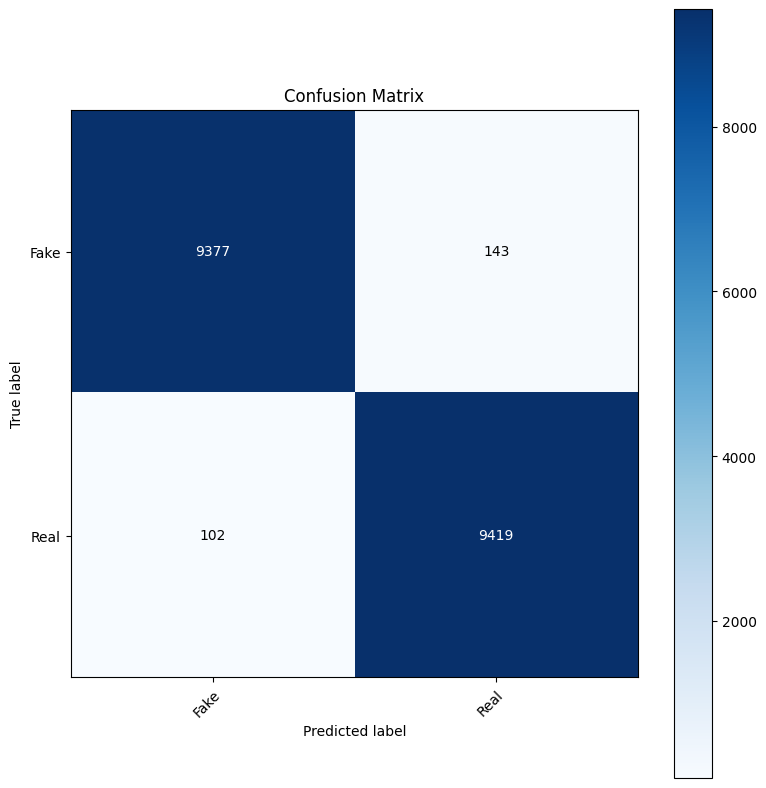


--- Generating ROC Curve ---
ROC curve saved to deepfake-vit-finetuned-gpu/roc_curve.png


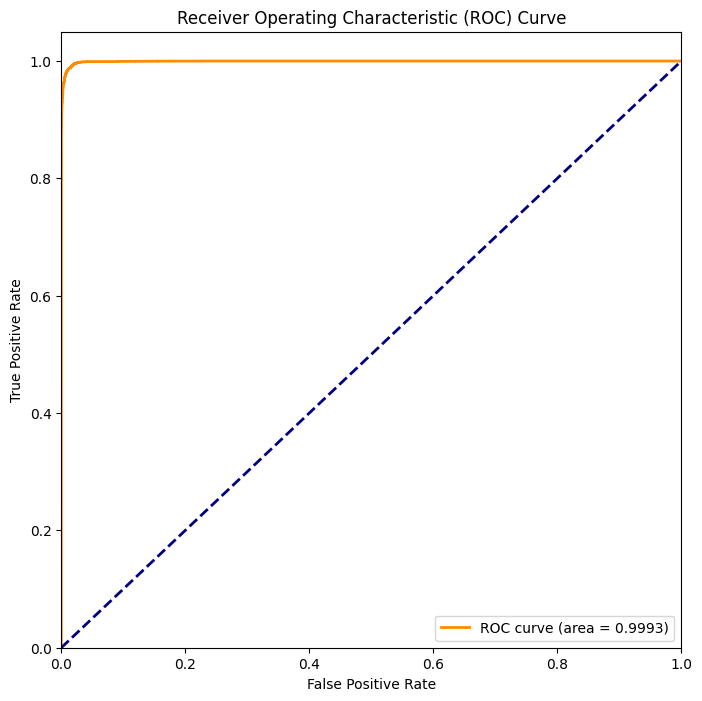


Script finished successfully.


In [ ]:

# 7. EVALUATION AND VISUALIZATION
# =================================================================================================
print("\nStarting final evaluation...")

# Get predictions on the test set
outputs = trainer.predict(test_data)
y_true = outputs.label_ids
y_pred_logits = outputs.predictions
y_pred_labels = np.argmax(y_pred_logits, axis=1)
y_pred_probs = softmax(y_pred_logits, axis=1)[:, 1]

print("\n--- Final Evaluation Metrics ---")
print(outputs.metrics)

# --- Classification Report ---
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred_labels, target_names=labels_list, digits=4))

# --- Confusion Matrix ---
print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred_labels)
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels_list, yticklabels=labels_list,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")
print(f"Confusion matrix saved to {OUTPUT_DIR}/confusion_matrix.png")
plt.show()

# --- ROC Curve and AUROC ---
print("\n--- Generating ROC Curve ---")
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
auroc_score = roc_auc_score(y_true, y_pred_probs)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(f"{OUTPUT_DIR}/roc_curve.png")
print(f"ROC curve saved to {OUTPUT_DIR}/roc_curve.png")
plt.show()

print("\nScript finished successfully.")

In [ ]:
import shutil

# Define source and destination paths
source_dir = OUTPUT_DIR # OUTPUT_DIR is defined in cell 
destination_dir = '/content/drive/MyDrive/deepfake-vit-finetuned-gpu'

# Copy the directory
shutil.copytree(source_dir, destination_dir)

print(f"Copied '{source_dir}' to '{destination_dir}'")

Copied 'deepfake-vit-finetuned-gpu' to '/content/drive/MyDrive/deepfake-vit-finetuned-gpu'


In [ ]:
from huggingface_hub import HfApi
from google.colab import userdata

HF_TOKEN = userdata.get('HF_TOKEN')
api = HfApi(token=HF_TOKEN)
api.upload_folder(
    folder_path="/content/deepfake-vit-finetuned-gpu",
    repo_id="sakshamkr1/deepfake-fb-deit-vit-224",
    repo_type="model",
)


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ckpoint-5356/optimizer.pt:   0%|          |  541kB /  687MB            

  ...nt-6695/model.safetensors:   0%|          |  552kB /  343MB            

  ...ned-gpu/model.safetensors:   0%|          |  138kB /  343MB            

  ...ckpoint-6695/optimizer.pt:   0%|          |  542kB /  687MB            

  ...nt-5356/model.safetensors:   0%|          |  551kB /  343MB            

  ...kpoint-5356/rng_state.pth:   7%|6         |   958B / 14.5kB            

  ...ckpoint-5356/scheduler.pt:   7%|6         |  97.0B / 1.47kB            

  ...nt-5356/training_args.bin:   7%|6         |   382B / 5.78kB            

  ...kpoint-6695/rng_state.pth:   7%|6         |   958B / 14.5kB            

  ...ckpoint-6695/scheduler.pt:   7%|6         |  97.0B / 1.47kB            

CommitInfo(commit_url='https://huggingface.co/sakshamkr1/deepfake-fb-deit-vit-224/commit/fbd19f9d7b6dfc5739624dabf0c282a49dd0533e', commit_message='Upload folder using huggingface_hub', commit_description='', oid='fbd19f9d7b6dfc5739624dabf0c282a49dd0533e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sakshamkr1/deepfake-fb-deit-vit-224', endpoint='https://huggingface.co', repo_type='model', repo_id='sakshamkr1/deepfake-fb-deit-vit-224'), pr_revision=None, pr_num=None)